In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.05
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 5

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [8]:
def _actor_initial_weight(actor):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.01]])
    
    Ad, Bd = discretized_system(A, B, control_interval * dt)
    
    K = dlqr(Ad,Bd,Q,R)[0]
    K = lqr(A,B,Q,R)[0]
    
    weights = []
    for i in range(len(actor.layers)):
        if i < 2:
            continue
        else:
            w, b = actor.layers[i].get_weights()
            # w, b = np.zeros_like(w), np.zeros_like(b)
            w, b = np.random.randn(w.shape[0], w.shape[1]) / 1., np.random.randn(b.shape[0]) / 1. 
            if i == 2:
                w[0][0] = K[0]
                w[1][0] = K[1]
            elif i == 4:
                w[0][0] = 1
                w[1][1] = 1
            else:
                w[0][0] = 1
            weights.append(w)
            weights.append(b)
    return weights

def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(2, activation="linear")(x)
    actor = Model(inputs=action_input, outputs=x)
    actor.summary()
    actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [9]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [10]:
#safe learning
l = 0.1
step = 300000
episode_step = int(200 * 0.05 / (dt * control_interval)) # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
# a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________


In [11]:
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
a.test(env, l=l, visualize=0, nb_max_episode_steps=episode_step, action_repetition=control_interval)

Testing for 1 episodes ...
Episode 1: reward: nan, steps: 40


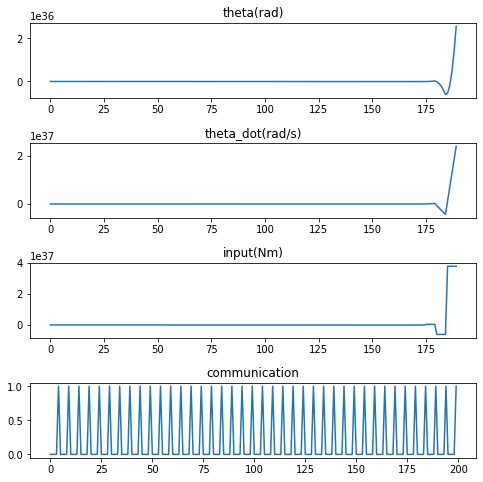

In [12]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [142]:
print(a.layers[4].get_weights())
# LQRの重みだけ大きすぎて、他の重みが同じような計算しかしなくなってる

[array([[ 1.6708455 , -2.6261177 ],
       [-0.4536044 ,  0.06555211],
       [ 0.19171396, -3.577578  ],
       [ 1.2969854 ,  4.695612  ],
       [-1.6315181 ,  2.983626  ],
       [ 0.2194768 ,  1.9341103 ],
       [-0.21658091, -4.2455235 ],
       [-0.4239911 , -3.5816257 ],
       [ 2.6188326 ,  0.6973056 ],
       [ 2.7679698 ,  3.9677534 ],
       [ 3.4326649 , -2.3517933 ],
       [ 1.5291673 , -3.7719707 ],
       [ 3.1383488 , -4.980534  ],
       [ 3.7697053 ,  2.3376274 ],
       [ 0.3606081 , -3.1280239 ],
       [ 1.2477865 ,  1.5982213 ]], dtype=float32), array([3.0436926 , 0.22727203], dtype=float32)]


In [15]:
x = np.array([0., 0.])
print(a.forward(x))

[ 4.133422  -0.6691612]


In [32]:
import inspect
logger = callback.callbacks[0]
print(logger.info_names)
#print(vars(logger))

for m in inspect.getmembers(logger):
    print(m[0])

dict_keys([])
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
_set_env
env
episode_rewards
info_names
infos
interval
interval_start
metrics
metrics_names
model
on_action_begin
on_action_end
on_batch_begin
on_batch_end
on_episode_begin
on_episode_end
on_epoch_begin
on_epoch_end
on_step_begin
on_step_end
on_train_begin
on_train_end
params
progbar
reset
set_model
set_params
step
train_start
